# Aceleration techniques for the implicit coupling

In some problems, especially stiff ones as seen in Tutorial 4, the explicit coupling is prone to instability and requires very small time steps. Implicit coupling is the only viable option, however the solution of the associated fixed-point may be difficult.

Let us remember the formulation of the fixed point problem as seen in the "Implicit Coupling" tutorial :
<!--- ![sketch](sketch_implicit_coupling.png "Figure 1 - Impicit algorithm") -->
<img src="sketch_implicit_coupling.png" alt="sketch" width="800"/>

With the three operators (subsystem integration $F$, coupling variables update $H$, interpolation $\Psi$), the implicit coupling equates to solving the following fixed-point problem:
$$\boxed{ {U}_{n+1}^\star = \underbrace{(\Psi \circ H \circ F)}_{G} (U_{n+1}^\star) }$$

Using a traditional fixed-point approach by simply looping as in the previous sketch will only converge if the operator $G$ is a contraction. The Lipschitz constant $L_\Psi$ associated to $\Psi$ is one here, since the interpolation does not change the endpoint value. That of $H$ can be assumed constant, denote $L_h$, as is the case when $H$ is linear or can be accurately linearised around the current solution vectors $y_i$.
Finaly, that of $F$ is associated to the time integration of the subsystems. Let us take the example where each system is integrated with a single backward Euler step: 
$$y_i^{n+1} = y_i^n + \Delta t f(y_i^{n+1}, u_i^{n+1})$$
Let us linearise $f$ around $(y^\star, u^\star)$:
$$y_i^{n+1} \approx y_i^n + \Delta t f(y^\star, u^\star)
 + \Delta t (\partial_y) f (y_{n+1} - y_\star) 
 + \Delta t (\partial_u) f (u_{n+1} - u_\star)$$


$$ \Leftrightarrow (\mathbb{I} - \Delta t (\partial_y f)) y_i^{n+1} = y_i^n + \Delta t f(y^\star, u^\star)
 - \Delta t (\partial_y f) y_\star
 + \Delta t (\partial_u f) (u_i^{n+1} - u_\star)$$
 
$$ \Leftrightarrow y_i^{n+1} = \underbrace{(\mathbb{I} - \Delta t (\partial_y f))^{-1} ( y_i^n + \Delta t f(y^\star, u^\star)
 - \Delta t (\partial_y f) y_\star - \Delta t (\partial_u f) u_\star )}_{R}
 + (\mathbb{I} - \Delta t (\partial_y f))^{-1} \Delta t (\partial_u f) u_i^{n+1}$$
 
  $$\Rightarrow y_i^{n+1} = R + (\mathbb{I} - \Delta t (\partial_y f))^{-1} \Delta t (\partial_u f) u_i^{n+1}$$
 
If we perturb the coupling variables, we get a perturbed solution :
  $$y_i^{n+1}+\delta y = R + (\mathbb{I} - \Delta t (\partial_y f))^{-1} \Delta t (\partial_u f) (u_i^{n+1} + \delta u)$$

Let us substracted the unperturbed and perturbed solutions:

  $$\delta y = (\mathbb{I} - \Delta t (\partial_y f))^{-1} \Delta t (\partial_u f) ~ \delta u$$

cas linéaire scalaire :


  $$\delta y = \dfrac{\Delta t}{1 - \lambda \Delta t} (\partial_u f) ~ \delta u$$

TODO: FINIR les 2 versions

Version théorique:
$$|| y^{n+1}(\hat{u}+\delta \hat{u}) - y^{n+1}(\hat{u}) || = C_x (\exp(L_0\Delta t) - 1) \max\limits_{t \in [t_{n},t_{n+1}]} ||\delta \hat{u}||$$


This may impose restrictions on the time step. Other solution procedures allow overcoming this limitation, they will be discussed in a subsequent tutorial.

## Toy model : conjugate heat transfer
We consider a one-dimensional test case representing the heat transfer between two solid slabs connected through, as used in Tutorial 4.
The model is implemented in the `examples/heat1D` folder of the `Rhapsopy` package. Let us import the necessary modules.

In [1]:
import numpy as np
np.seterr(divide="raise")
import scipy.integrate
import matplotlib.pyplot as plt

from rhapsopy.examples.heat1D.model.setup_heat import getSetup
from rhapsopy.examples.heat1D.model.coupler_heat import Coupler
from rhapsopy.coupling import Orchestrator
from rhapsopy.accelerators import NewtonSolver, DampedNewtonSolver, JFNKSolver, AitkenUnderrelaxationSolver, FixedPointSolver, ExplicitSolver

N=50 # number of grid points in each domain
rho1_sur_rho2 = 1. # ratio of the densities of both solids
tf = 1e3 # physical time simulated
coupling_modes = ('neumann_extrap', 'dirichlet_extrap') # classic coupling-scheme (Neumann-Dirichlet)

# retrieve the data structure for the solvers associated with each slab
options1, options2 = getSetup(N1=N+1,N2=N+1, rho1_sur_rho2=rho1_sur_rho2, bReactive=False)

# instantiate the coupler object
coupler = Coupler(options1, options2, coupling_modes=coupling_modes)
coupler.adaptive_subsolves = True # each subsystem is integrated with adaptive time scheme
coupler.method = 'BDF' # each subsystem is integrated using Scipy's scheme

y0_global = np.hstack( (options1['y0'],
                        options2['y0']) ) # overall initial state vector
x_global =  np.hstack( (options1['solid']['mesh']['cellX'],
                        options2['solid']['mesh']['cellX']) ) # concatenation of both 1D meshes for visualisation

Let us now prepare our simulation orchestrator:

In [2]:
max_nt = 20 # maximum number of coupling steps allowed
order = 3 # degree of the polynomial approximation of the coupling variables
rtol = 1e-3 # error tolerance for time adaptation
first_step = 1e-4 # size of the first time step to be tried

keepUniformSampling = True # when the time step is changed, the previous sampling points are resampled uniformly (may help with stability)
embedded_method = True # use the embedded error estimate method
higher_order_embedded = True # the embedded method is one order higher than the main method, otherwise it is one order lower

In the case of an implicit coupling, we need to specify which fixed-point solver must be used. Several options are available in `Rhapsopy` as the following classes:
- the **standard fixed-point solver** `FixedPointSolver`, which simply naively iterates on each step, each time interpolating the coupling variables of the previous iterate. It may suffer from slow convergence or divergence issues if the time step is too large ;
- the **dynamically-relaxed Aitken fixed-point solver** `AitkenUnderrelaxationSolver`, which improves the convergence of the previous algorithm by using an under-relaxation approach with a dynamically selected relaxation factor ;
- the **basic Newton solver** `NewtonSolver`, which solves the fixed-point with a full newton approach, with a Jacobian update after each Newton step.
- the **Newton solver with damping** `DampedNewtonSolver` which uses a dynamically damped Newton algorithm to improve convergence, and allows for more efficient Jacobian reuse.
- the **Jacobien-Free Newton-Krylov solver** `JFNKSolver` which avoid forming the Jacobian of the fixed-point problem. Currently unpreconditioned.

We currently recommand the Aitken solver or, when its convergence is poor, the damped Newton solver. Interface Quasi-Newton solvers are planned for future updates.

A maximum number of iterations (here defined as the number of subsystem integration calls) can be prescribed. If this number of iteration is reached, the time step is reduced.

Let us see how they compare in terms of performance (number of subsystem integrations):

In [3]:
# Choose the fixed-point solver
solvers = [FixedPointSolver, AitkenUnderrelaxationSolver, NewtonSolver, DampedNewtonSolver, JFNKSolver]
outs = []

for solver in solvers:
    # instantiate the orchestrator class
    conductor = Orchestrator(coupler=coupler, order=order)

    # specify the error estimation method
    conductor.embedded_method = embedded_method
    conductor.higher_order_embedded = higher_order_embedded
    conductor.NITER_MAX = 100
    conductor.interfaceSolver = solver

    conductor.logger.setLevel(30) # printing level for the orchestration process
    conductor.solverlogger.setLevel(100) # printing level for the fixed-point solver
    coupler.logger.setLevel(100) # printing level for the coupler
    
    outCoupled = conductor.adaptive_integration(y0=y0_global,
                                            t_span=np.array([0.,tf]),
                                            first_step=first_step,
                                            atol=rtol, rtol=rtol,
                                            max_nt=max_nt,
                                            keepUniformSampling=keepUniformSampling)

    outCoupled = coupler.complementOutput(outCoupled) # compute additional variables as post-processing

    # count total number of subsystem integration calls
    nWR = sum(outCoupled.WR_iters)
    outCoupled.nWR1 = nWR
    if conductor.embedded_method: #account for the cost of the embedded method
        nWR2 = sum(outCoupled.WR_iters2)
        nWR = nWR + nWR2
        outCoupled.nWR2 = nWR2
    outCoupled.nWR = nWR
    
    outCoupled.conductor = conductor
    
    print('Coupled solution obtained in {} s, {} steps ({} accepted, {} rejected, {} failed), {} WR iterations'.format(
           outCoupled.CPUtime, outCoupled.nsteps_total, outCoupled.nsteps_accepted,
           outCoupled.nsteps_rejected, outCoupled.nsteps_failed, nWR))
    
    outs.append( outCoupled )

rhapsopy.coupling - Adaptive integration begins
C:\Anaconda3\envs\baseClone\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `uband`, `lband`.
  warn("The following arguments have no effect for a chosen solver: {}."
rhapsopy.coupling - maximum number of steps reached
rhapsopy.coupling - Adaptive integration begins


Coupled solution obtained in 1.7326505184173584 s, 21 steps (20 accepted, 1 rejected, 0 failed), 168 WR iterations


rhapsopy.coupling - maximum number of steps reached
rhapsopy.coupling - Adaptive integration begins


Coupled solution obtained in 19.272587299346924 s, 26 steps (20 accepted, 1 rejected, 5 failed), 314 WR iterations


rhapsopy.coupling - maximum number of steps reached
rhapsopy.coupling - Adaptive integration begins


Coupled solution obtained in 9.40805959701538 s, 23 steps (20 accepted, 3 rejected, 0 failed), 213 WR iterations


rhapsopy.coupling - maximum number of steps reached
rhapsopy.coupling - Adaptive integration begins


Coupled solution obtained in 6.551192045211792 s, 23 steps (20 accepted, 3 rejected, 0 failed), 127 WR iterations


rhapsopy.coupling - maximum number of steps reached


Coupled solution obtained in 13.208808183670044 s, 23 steps (20 accepted, 3 rejected, 0 failed), 297 WR iterations


In [4]:
#%% Process detailed step info
from rhapsopy.coupling import process_step_info

for outCoupled in outs:
    outCoupled.step_info = process_step_info(outCoupled)
    for key in outCoupled.step_info.keys():
        outCoupled.step_info[key]['nt'] = np.array( [ np.argmin(abs(outCoupled.t-t)) for t in outCoupled.step_info[key]['tn'] ])
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0.98, 'Comparison of the various solvers (order 3, rtol=1.0e-03)')

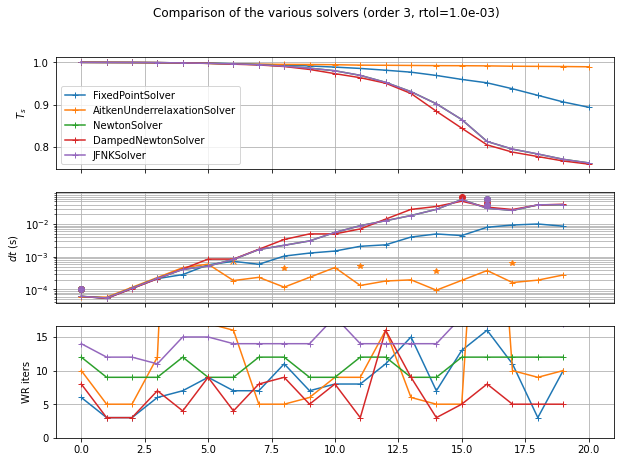

In [14]:
#%% Analyse time step adaptation
bPlotOrders=False # plot order evolution
bPlotWR=True # plot WR iterations
bPlotStepInfo=True # plot failed steps and others
bTimeAxis=False # plot versus time or index

fig, ax = plt.subplots(2+1*bPlotWR+1*bPlotOrders, 1, figsize=(10,7), sharex=True)

for outCoupled in outs:
    if bTimeAxis:
      Xdata = outCoupled.t
      key_infox = 'tn'
    else:
      Xdata = np.array(range(outCoupled.t.size))
      key_infox = 'nt'

    # plot surface temperature
    ix=0
    p,=ax[ix].plot(Xdata, outCoupled.Ts, marker='+', label=str(outCoupled.conductor.interfaceSolver).split('.')[-1][:-2])
    current_color = p.get_color()
    ax[ix].set_ylabel(r'$T_s$')

    # plot time step evolution
    ix+=1
    ax[ix].semilogy(Xdata[:-1], np.diff(outCoupled.t), marker='+', color=current_color)
    if bPlotStepInfo: # plot failed and refused steps
      ax[ix].semilogy(outCoupled.step_info['ERRORTOOHIGH'][key_infox], outCoupled.step_info['ERRORTOOHIGH']['dt'],
                              marker='o', linestyle='',
                              color=current_color, label=None) #'rejected')
      ax[ix].semilogy(outCoupled.step_info['WRNONCONVERGENCE'][key_infox], outCoupled.step_info['WRNONCONVERGENCE']['dt'],
                              marker='*', linestyle='',
                              color=current_color, label=None) #main WR failed')
      if conductor.embedded_method:
          ax[ix].semilogy(outCoupled.step_info['WRNONCONVERGENCE2'][key_infox], outCoupled.step_info['WRNONCONVERGENCE2']['dt'],
                          marker='x', linestyle='',  color=current_color, label=None) #'embedded WR failed')
    ax[ix].set_ylabel(r'$dt$ (s)')
    ax[ix].grid(which='minor')
    ax[ix].legend(framealpha=0, ncol=3)

    if bPlotOrders: # plot the evolution of the prediction orders
      ix+=1
      for i in range(  outCoupled.p_hist.shape[1] ):
        ax[ix].plot(Xdata[:-1], outCoupled.p_hist[:,i], marker='+', color=current_color, label=f'var {i}')
      ax[ix].set_ylabel(r'order')
      ax[ix].set_ylim(0, order+1)
      ax[ix].set_yticks(range(order+1), minor=True)
      ax[ix].yaxis.grid(which='minor')

    if bPlotWR: # plot history of fixed-point iteration count
      ix+=1
      ax[ix].plot(Xdata[:-1], outCoupled.WR_iters +  outCoupled.WR_iters2, marker='+', color=current_color, label='main')
      #ax[ix].plot(Xdata[:-1], outCoupled.WR_iters, marker='+', color=current_color, label='main')
      #if conductor.embedded_method:
      #    ax[ix].plot(Xdata[:-1], outCoupled.WR_iters2, marker='+', linestyle='--', color=current_color, label='embedded')
      ax[ix].set_ylabel(r'WR iters')
      ax[ix].set_ylim(0,None)

# finalise visual appearance
ax[0].legend()
for ix in range(len(ax)):
  ax[ix].grid()
fig.suptitle(f'Comparison of the various solvers (order {conductor.order}, rtol={rtol:.1e})')
